<a href="https://colab.research.google.com/github/chauhanneha16/Audio_Spoofing/blob/main/spoofing_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [20]:
!chmod 600 /root/.kaggle/kaggle.json

In [22]:
%env KAGGLE_CONFIG_DIR=/root/.kaggle/

env: KAGGLE_CONFIG_DIR=/root/.kaggle/


In [16]:
import zipfile
zip_ref = zipfile.ZipFile('/content/asvpoof-2019-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [1]:
# Define paths and parameters
DATASET_PATH = "/content/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [4]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [5]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-78.88214 , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-71.71661 , -77.353325, -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-57.14656 , -59.50205 , -57.573334, ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [-69.18776 , -63.819817, -67.85419 , ...,   0.      ,
            0.      ,   0.      ],
         [-70.22391 , -64.85324 , -68.70045 , ...,   0.      ,
            0.      ,   0.      ],
         [-72.25124 , -66.18086 , -68.856   , ...,   0.      ,
            0.      ,   0.      ]],
 
        [[-72.254776, -78.77455 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-69.887405, -76.79361 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-57.00554 , -52.203255, -48.832603, ..., -73.142075,
          -71.93824 , -75.95265 ],
         ...,
         [-80.      , -68.084435, -64.63213 , ..., -47.64021 ,
          -42.370796, -4

In [6]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

# Define Transformer model architecture
input_shape = (N_MELS, X_train.shape[2])  # Input shape for Transformer (time steps, features)
num_classes = NUM_CLASSES

# Input layer
inputs = Input(shape=input_shape)

# Positional encoding
position_embeddings = Embedding(input_shape[0], input_shape[1])(tf.range(input_shape[0]))
x = inputs + position_embeddings

# Transformer layers
num_heads = 8
ff_dim = 64
num_layers = 4
embedding_dim = 32

for _ in range(num_layers):
    # Multi-head self-attention
    x = LayerNormalization()(x)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = x + attention_output

  # Feed-forward layer
    x = LayerNormalization()(x)
    x_ff = Dense(units=ff_dim, activation='relu')(x)
    x_ff = Dropout(0.1)(x_ff)
    x_ff = Dense(units=109, activation='relu')(x_ff)
    x_ff = Dropout(0.1)(x_ff)
    x = x + x_ff

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 109)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 109)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 109)       │            218 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 109)       │        112,493 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 109)       │              0 │ layer_normalization[0… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 109)       │            218 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 64)        │          7,040 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 64)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 109)       │          7,085 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 109)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128, 109)       │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 128, 109)       │            218 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 128, 109)       │        112,493 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 128, 109)       │              0 │ layer_normalization_2… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 128, 109)       │            218 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 508,436 (1.94 MB)

 Trainable params: 508,436 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9421 - loss: 0.1281 - val_accuracy: 0.9214 - val_loss: 0.1794
Epoch 2/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9429 - loss: 0.1268 - val_accuracy: 0.9169 - val_loss: 0.1787
Epoch 3/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9395 - loss: 0.1302 - val_accuracy: 0.9160 - val_loss: 0.1758
Epoch 4/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9433 - loss: 0.1262 - val_accuracy: 0.9192 - val_loss: 0.1732
Epoch 5/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9442 - loss: 0.1223 - val_accuracy: 0.9216 - val_loss: 0.1742
Epoch 6/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9443 - loss: 0.1241 - val_accuracy: 0.9187 - val_loss: 0.1738
Epoch 7/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9464 - loss: 0.1199 - val_accuracy: 0.9210 - val_loss: 0.1751
Epoch 8/10
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9462 - loss: 0

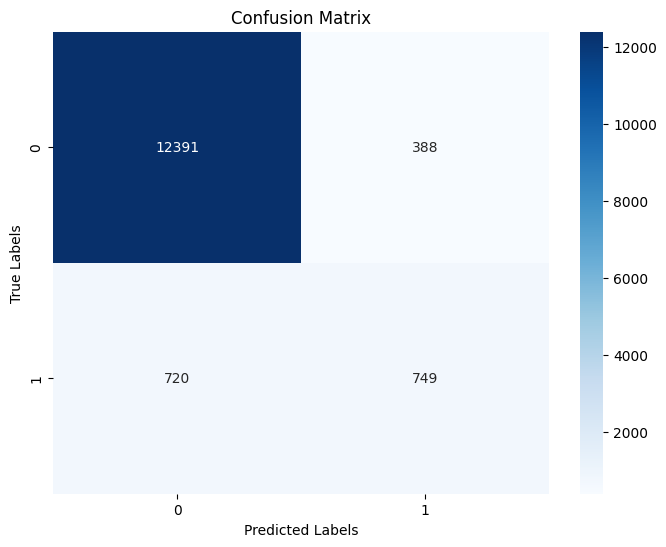

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)
# Print the number of samples for training and testing
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict using the trained model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
